In [ ]:
# From https://web.archive.org/web/20160125032147/http://shogun-toolbox.org/static/notebook/current/bss_audio.html

This notebook illustrates Blind Source Seperation(BSS) on audio signals using Independent Component Analysis (ICA) in Shogun. We generate a mixed signal and try to seperate it out using Shogun's implementation of ICA & BSS called JADE.

My favorite example of this problem is known as the cocktail party problem where a number of people are talking simultaneously and we want to separate each persons speech so we can listen to it separately. Now the caveat with this type of approach is that we need as many mixtures as we have source signals or in terms of the cocktail party problem we need as many microphones as people talking in the room.

Let's get started, this example is going to be in python and the first thing we are going to need to do is load some audio files. To make things a bit easier further on in this example I'm going to wrap the basic scipy wav file reader and add some additional functionality. First I added a case to handle converting stereo wav files back into mono wav files and secondly this loader takes a desired sample rate and resamples the input to match. This is important because when we mix the two audio signals they need to have the same sample rate.

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample

def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)


Next we're going to need a way to play the audio files we're working with (otherwise this wouldn't be very exciting at all would it?). In the next bit of code I've defined a wavPlayer class that takes the signal and the sample rate and then creates a nice HTML5 webplayer right inline with the notebook.

In [2]:
import sys
import StringIO
import base64
import struct  

from IPython.display import display
from IPython.core.display import HTML

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))



Now that we can load and play wav files we actually need some wav files! I found the sounds from Starcraft to be a great source of wav files because they're short, interesting and remind me of my childhood. You can download Starcraft wav files here: http://wavs.unclebubby.com/computer/starcraft/ among other places on the web or from your Starcraft install directory (come on I know its still there).
Another good source of data (although lets be honest less cool) is ICA central and various other more academic data sets: http://perso.telecom-paristech.fr/~cardoso/icacentral/base_multi.html. Note that for lots of these data sets the data will be mixed already so you'll be able to skip the next few steps.
kay lets load up an audio file. I chose the Terran Battlecruiser saying "Good Day Commander". In addition to the creating a wavPlayer I also plotted the data using Matplotlib (and tried my best to have the graph length match the HTML player length). Have a listen!

In [3]:
# change to the shogun-data directory
import os
#os.chdir('../../../data/ica')

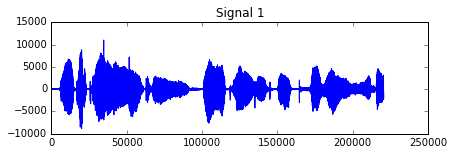

In [4]:
%matplotlib inline
import pylab as pl

# load
fs1,s1 = load_wav('ravenpoeshort.wav') # The Raven - Poe

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wavPlayer(s1, fs1)

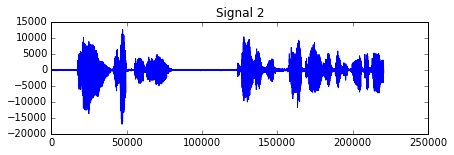

In [5]:
# load
fs2,s2 = load_wav('JohnCh03short.wav') # John Ch02 - Douay Rheims Bible

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s2)
pl.title('Signal 2')
pl.show()

# player
wavPlayer(s2, fs2)

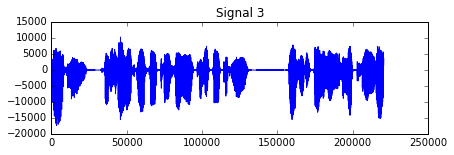

In [6]:
# load
fs3,s3 = load_wav('timemachineshort.wav') # The Time Machine by H.G. Wells

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s3)
pl.title('Signal 3')
pl.show()

# player
wavPlayer(s3, fs3)

Now we've got our audio files loaded up into our example program. The next thing we need to do is mix them together!
First another nuance - what if the audio clips aren't the same length? The solution I came up with for this was to simply resize them all to the length of the longest signal, the extra length will just be filled with zeros so it won't affect the sound.
The signals are mixed by creating a mixing matrix  A  and taking the dot product of  A  with the signals  S .
Afterwards I plot the mixed signals and create the wavPlayers, have a listen!

In [7]:
# Adjust for different clip lengths
fs = fs1
length = max([len(s1), len(s2), len(s3)])
s1.resize((length,1))
s2.resize((length,1))
s3.resize((length,1))

S = (np.c_[s1, s2, s3])
S = S/S.std(axis=0)
print S.std(axis=0)
print np.shape(S)

[ 1.  1.  1.]
(220500, 3)


In [8]:
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
print np.shape(X)

(220500, 3)


3
(220500,)


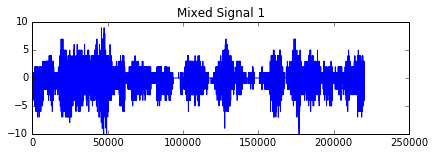

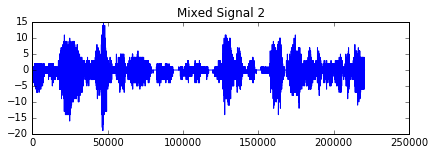

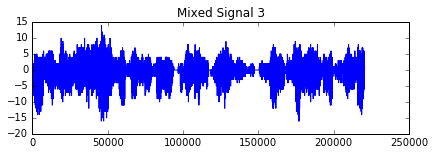

In [9]:
print X.shape[1]
print np.shape(X[:,0])
# Mixed Signal i
for i in range(X.shape[1]):
    pl.figure(figsize=(6.75,2))
    pl.plot((X[:,i]).astype(np.int16))
    pl.title('Mixed Signal %d' % (i+1))
    pl.show()
    wavPlayer((X[:,i]).astype(np.int16), fs)

In [11]:
from sklearn.decomposition import FastICA, PCA
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print np.shape(A_)
print np.shape(S_)
print ica.mean_
np.shape(X)

(3, 3)
(220500, 3)
[-0.00169975 -0.00121669 -0.00238877]


(220500, 3)

In [12]:
# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_,A_.T) + ica.mean_)

In [13]:
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

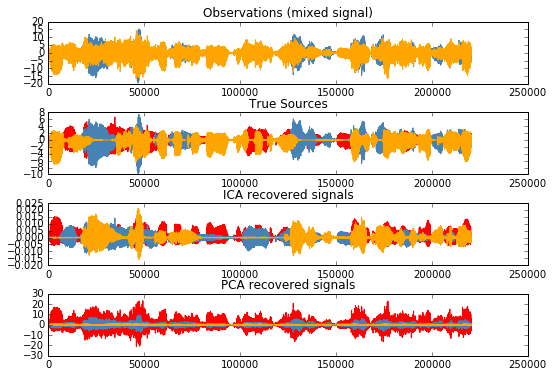

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 1.2, 1.2, 0.26, 0.46)
plt.show()